In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import scipy.stats as stats

# Travail à faire
Vous êtes missionné sur le projet de nettoyage et exploration des données en interne, afin de déterminer la faisabilité de cette idée d’application de Santé publique France.

# 1. Présentation générale du jeu de données

In [2]:
produit = pd.read_csv('prod.csv', sep='\t', low_memory=False)
produit.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- La dimension du dataframe

In [3]:
produit.shape

(320772, 162)

- La méthode `info` nous donne des indications globales

In [4]:
produit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


### Aperçu des valeurs manquantes

- Le nombre de valeur manquante par colonne

In [5]:
produit.isna().sum()

code                           23
url                            23
creator                         2
created_t                       3
created_datetime                9
                            ...  
carbon-footprint_100g      320504
nutrition-score-fr_100g     99562
nutrition-score-uk_100g     99562
glycemic-index_100g        320772
water-hardness_100g        320772
Length: 162, dtype: int64

<AxesSubplot:>

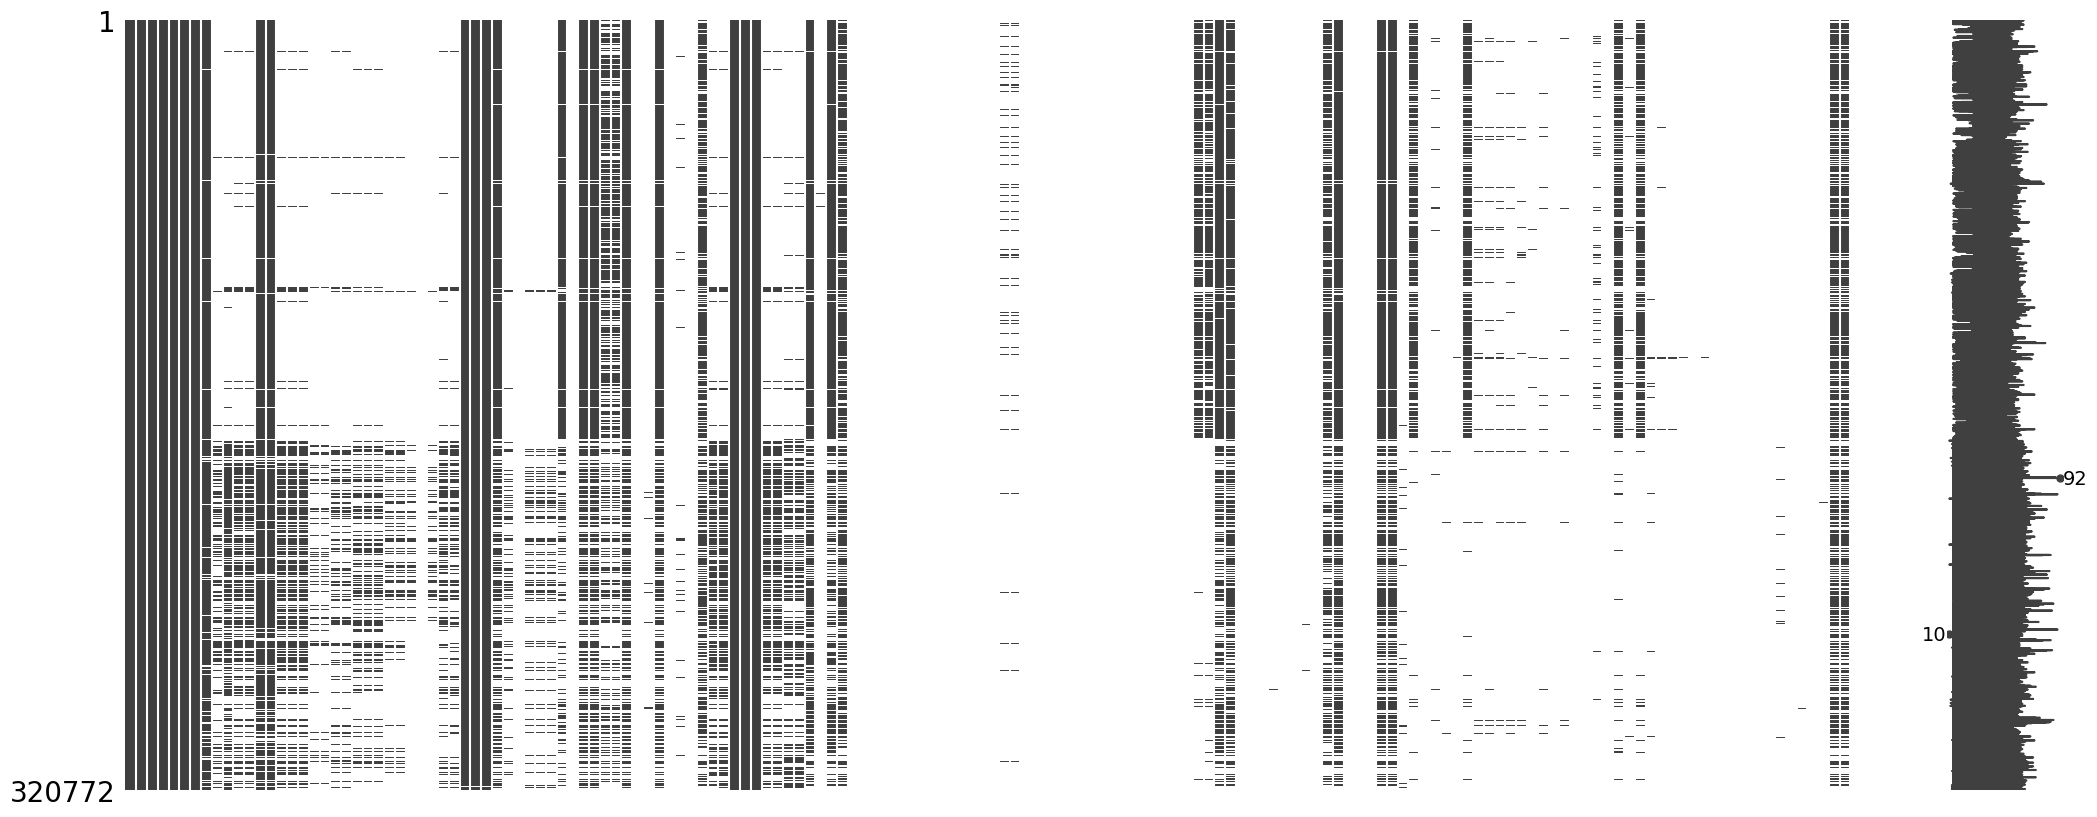

In [6]:
msno.matrix(produit)

#### La majorité des variables n'est pas renseignée (- de 50 variables sont remplis à plus de 50%) les autres sont quasiment vides.

### Sélection des feature sur lesquels nous allons travailler, la plupart de ces variables ont moins de moins 50% de valeurs manquantes.

In [7]:
echan = ['product_name','fiber_100g','proteins_100g','vitamin-a_100g','vitamin-c_100g','fat_100g','carbohydrates_100g','sugars_100g','sodium_100g','nutrition_grade_fr','pnns_groups_1']
echan0 = produit[echan]

### Aperçu du nombre des valeurs manquantes

In [8]:
echan0.isna().sum()

product_name           17762
fiber_100g            119886
proteins_100g          60850
vitamin-a_100g        183218
vitamin-c_100g        179905
fat_100g               76881
carbohydrates_100g     77184
sugars_100g            75801
sodium_100g            65309
nutrition_grade_fr     99562
pnns_groups_1         229259
dtype: int64

### Le pourcentage de valeurs manquantes dans chaque colonne.

In [9]:
miss = echan0.isna().mean()*100
miss

product_name           5.537266
fiber_100g            37.374210
proteins_100g         18.969860
vitamin-a_100g        57.117828
vitamin-c_100g        56.085007
fat_100g              23.967491
carbohydrates_100g    24.061951
sugars_100g           23.630803
sodium_100g           20.359944
nutrition_grade_fr    31.038245
pnns_groups_1         71.471014
dtype: float64

<AxesSubplot:>

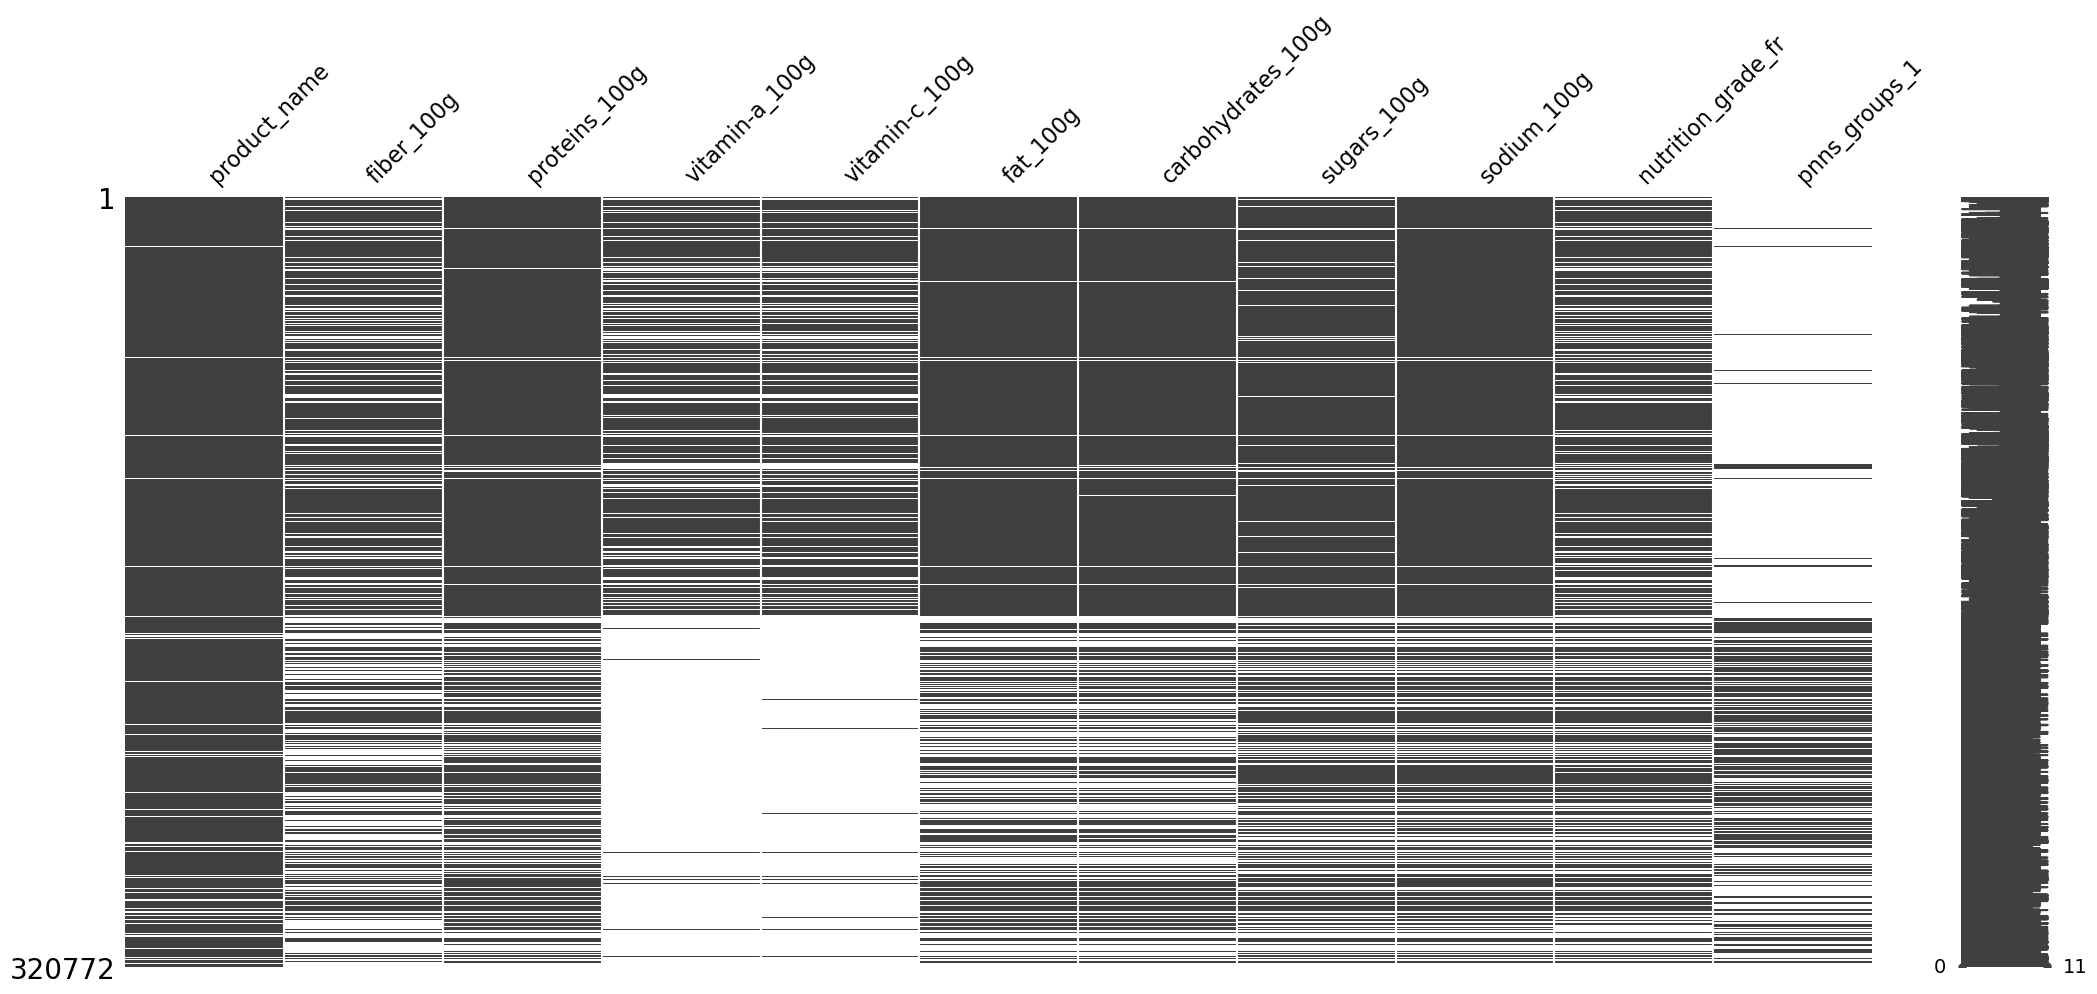

In [10]:
msno.matrix(echan0)

# 2. Nettoyage des données

In [11]:
echan0.shape

(320772, 11)

## 2.1 Traitement des valeurs manquantes

#### - Suppression des lignes dont le nom produit n'est pas renseigné et autres nom de produit non conforme

In [12]:
echan0 = echan0.dropna(subset=['product_name'])

In [13]:
echan0 = echan0.dropna(subset=['pnns_groups_1'])

In [14]:
echan0 = echan0.dropna(subset=['nutrition_grade_fr'])

In [15]:
echan0.drop(echan0[echan0['product_name'] == ' '].index, inplace = True)

#### - Filtrage sur les differents 'Features' fibre, proteins_100g, vitamin-c_100g, sodium_100g, carbohydrates_100g, etc. 

In [16]:
echan0 = echan0.drop(echan0[(echan0['fiber_100g'] < 0) & (echan0['fiber_100g'] < 100 )].index)

In [17]:
echan0 = echan0.drop(echan0[(echan0['proteins_100g'] < 0) & (echan0['proteins_100g'] < 100 )].index)

In [18]:
echan0 = echan0.drop(echan0[(echan0['vitamin-a_100g'] < 0) & (echan0['vitamin-a_100g'] < 100 )].index)

In [19]:
echan0 = echan0.drop(echan0[(echan0['vitamin-c_100g'] < 0) & (echan0['vitamin-c_100g'] < 100 )].index)

In [20]:
echan0 = echan0.drop(echan0[(echan0['sodium_100g'] < 0) & (echan0['sodium_100g'] < 100 )].index)

In [21]:
echan0 = echan0.drop(echan0[(echan0['carbohydrates_100g'] < 0) & (echan0['carbohydrates_100g'] < 100)].index)

In [22]:
echan0 = echan0.drop(echan0[(echan0['fat_100g'] < 0) & (echan0['fat_100g'] < 100)].index)

In [23]:
echan0 = echan0.drop(echan0[(echan0['sugars_100g'] < 0) & (echan0['sugars_100g'] < 100)].index)

In [24]:
dupli = echan0[echan0.duplicated(keep=False)]

In [25]:
echan0 = echan0.drop_duplicates(keep='first')

In [26]:
echan0 = echan0.set_index('product_name', drop=True)

In [27]:
echan0

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,nutrition_grade_fr,pnns_groups_1
product_name,,,,,,,,,,
Lion Peanut x2,2.500,2.500,NaN,NaN,20.00,70.00,57.500,0.038000,e,unknown
Salade Cesar,2.000,22.000,0.000000,0.000000,12.00,23.00,0.000,0.850000,c,Fruits and vegetables
Chaussons tressés aux pommes,2.000,3.330,0.000000,0.001600,10.70,38.70,24.700,0.255000,c,Sugary snacks
Pain Burger Artisan,2.220,10.000,0.000000,0.000000,1.11,53.30,1.110,0.600000,b,unknown
Quiche Lorraine,0.357,5.360,0.000011,0.000429,6.79,7.86,0.714,0.196000,b,Composite foods
...,...,...,...,...,...,...,...,...,...,...
Santa Cruz Chilli & Lime Dressing,0.600,0.300,NaN,NaN,6.90,23.10,16.700,0.213000,c,Fat and sauces
Fisherman's Friend Miel-Citron,1.470,0.004,NaN,NaN,1.30,95.31,0.100,0.000394,b,Sugary snacks
Nature cheddar and red onion crisps,5.600,7.800,NaN,NaN,NaN,NaN,1.800,0.531496,c,Salty snacks


In [28]:
tr_knn = echan0.drop(['nutrition_grade_fr','pnns_groups_1'], axis=1)
tr_knn

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
product_name,,,,,,,,
Lion Peanut x2,2.500,2.500,NaN,NaN,20.00,70.00,57.500,0.038000
Salade Cesar,2.000,22.000,0.000000,0.000000,12.00,23.00,0.000,0.850000
Chaussons tressés aux pommes,2.000,3.330,0.000000,0.001600,10.70,38.70,24.700,0.255000
Pain Burger Artisan,2.220,10.000,0.000000,0.000000,1.11,53.30,1.110,0.600000
Quiche Lorraine,0.357,5.360,0.000011,0.000429,6.79,7.86,0.714,0.196000
...,...,...,...,...,...,...,...,...
Santa Cruz Chilli & Lime Dressing,0.600,0.300,NaN,NaN,6.90,23.10,16.700,0.213000
Fisherman's Friend Miel-Citron,1.470,0.004,NaN,NaN,1.30,95.31,0.100,0.000394
Nature cheddar and red onion crisps,5.600,7.800,NaN,NaN,NaN,NaN,1.800,0.531496


####  Remplissage des valeurs manquantes par la methode KNNImputer

In [29]:
imputer = KNNImputer(n_neighbors=4)
imputed = imputer.fit_transform(tr_knn)
df_imputed = pd.DataFrame(imputed, columns=tr_knn.columns)
df_imputed.head()

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
0,2.500,2.50,0.000000,0.000000,20.00,70.00,57.500,0.038
1,2.000,22.00,0.000000,0.000000,12.00,23.00,0.000,0.850
2,2.000,3.33,0.000000,0.001600,10.70,38.70,24.700,0.255
3,2.220,10.00,0.000000,0.000000,1.11,53.30,1.110,0.600
4,0.357,5.36,0.000011,0.000429,6.79,7.86,0.714,0.196


In [30]:
d1 = echan0.drop(['fiber_100g','proteins_100g','vitamin-a_100g','vitamin-c_100g','fat_100g','carbohydrates_100g','sugars_100g','sodium_100g'], axis=1).reset_index()

In [31]:
echan = pd.concat([d1, df_imputed], axis=1)
echan

,product_name,nutrition_grade_fr,pnns_groups_1,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
0,Lion Peanut x2,e,unknown,2.500,2.500,0.000000,0.000000,20.00,70.00,57.500,0.038000
1,Salade Cesar,c,Fruits and vegetables,2.000,22.000,0.000000,0.000000,12.00,23.00,0.000,0.850000
2,Chaussons tressés aux pommes,c,Sugary snacks,2.000,3.330,0.000000,0.001600,10.70,38.70,24.700,0.255000
3,Pain Burger Artisan,b,unknown,2.220,10.000,0.000000,0.000000,1.11,53.30,1.110,0.600000
4,Quiche Lorraine,b,Composite foods,0.357,5.360,0.000011,0.000429,6.79,7.86,0.714,0.196000
...,...,...,...,...,...,...,...,...,...,...,...
59768,Santa Cruz Chilli & Lime Dressing,c,Fat and sauces,0.600,0.300,0.000039,0.003750,6.90,23.10,16.700,0.213000
59769,Fisherman's Friend Miel-Citron,b,Sugary snacks,1.470,0.004,0.000225,0.289000,1.30,95.31,0.100,0.000394
59770,Nature cheddar and red onion crisps,c,Salty snacks,5.600,7.800,0.000124,0.000625,31.10,10.50,1.800,0.531496
59771,Tartines craquantes bio au sarrasin,a,Cereals and potatoes,5.900,13.000,0.000000,0.000000,2.80,74.80,2.600,0.267717


#### - Le pourcentage de données manquantes

In [32]:
miss = echan.isna().mean()*100
miss

product_name          0.0
nutrition_grade_fr    0.0
pnns_groups_1         0.0
fiber_100g            0.0
proteins_100g         0.0
vitamin-a_100g        0.0
vitamin-c_100g        0.0
fat_100g              0.0
carbohydrates_100g    0.0
sugars_100g           0.0
sodium_100g           0.0
dtype: float64

### 2.2  Recherche et suppression des duplicatas

In [33]:
dupli = echan[echan.duplicated(keep=False)]
dupli

,product_name,nutrition_grade_fr,pnns_groups_1,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
152,Goldfish baked snack crackers Cheddar,d,unknown,3.33,10.0,0.000000,0.00000,16.7,66.7,0.0,0.833000
153,Goldfish baked snack crackers Cheddar,d,unknown,3.33,10.0,0.000000,0.00000,16.7,66.7,0.0,0.833000
314,Tomato Ketchup,d,Fat and sauces,0.00,0.0,0.000176,0.00706,0.0,29.4,23.5,0.941000
1294,Toblerone,e,unknown,2.20,5.6,0.000000,0.00000,29.5,60.5,59.5,0.059055
1690,Tomato Ketchup,d,Fat and sauces,0.00,0.0,0.000176,0.00706,0.0,29.4,23.5,0.941000
...,...,...,...,...,...,...,...,...,...,...,...
53352,Toblerone,e,unknown,2.20,5.6,0.000000,0.00000,29.5,60.5,59.5,0.059055
53747,Grana Padano râpé,d,Milk and dairy products,0.00,33.0,0.000261,0.00000,29.0,0.0,0.0,0.590551
54747,Huile végétale pour friture,c,Fat and sauces,0.00,0.0,0.000000,0.00000,92.0,0.0,0.0,0.000000
57866,Saindoux pur porc,d,Fat and sauces,0.00,0.0,0.000100,0.00000,100.0,0.0,0.0,0.000000


In [34]:
echan = echan.drop_duplicates(keep='first')

#### Verification après nettoyage

In [35]:
echan.duplicated().sum()

0

In [36]:
echan.shape

(59703, 11)

## Echantillonnage avec la fonction *sample()*

In [37]:
jeu0 = echan.sample(frac=0.9)
jeu0

,product_name,nutrition_grade_fr,pnns_groups_1,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
6694,Foie de veau,a,Fish Meat Eggs,0.00,20.0,0.000000,0.000000,4.8,2.9,0.0,0.074803
49950,Bonbons craie,d,Sugary snacks,0.00,1.9,0.000000,0.001500,1.8,88.0,74.0,0.070866
42388,Tropifrutti,d,Sugary snacks,0.55,4.5,0.000000,0.012750,0.5,82.0,63.0,0.011811
43043,Oro di Parma Tomaten stückig,a,Fruits and vegetables,0.85,1.1,0.020847,0.027250,0.2,3.0,3.0,0.078740
46701,Butter,e,Fat and sauces,0.00,0.5,0.000707,0.000000,81.7,0.0,0.0,0.800000
...,...,...,...,...,...,...,...,...,...,...,...
8437,Velouté de Poireaux Pommes de Terre et Pointe ...,c,Composite foods,0.70,1.0,0.000095,0.004926,2.5,4.8,0.8,0.750000
35719,Poire,e,Beverages,0.00,0.0,0.000090,0.025000,0.0,11.0,9.5,0.003000
11573,filets de thon au naturel,b,Fish Meat Eggs,0.00,28.0,0.000000,0.000275,1.3,0.0,0.0,0.433071
43477,Hafer Creme Cuisine,b,Cereals and potatoes,0.50,0.3,0.000114,0.004040,7.7,5.6,4.8,0.039370


In [38]:
jeu0_C=jeu0

In [39]:
df= pd.read_csv('df.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [40]:
jeu0.duplicated().sum()

0

In [41]:
jeu0.dtypes

product_name           object
nutrition_grade_fr     object
pnns_groups_1          object
fiber_100g            float64
proteins_100g         float64
vitamin-a_100g        float64
vitamin-c_100g        float64
fat_100g              float64
carbohydrates_100g    float64
sugars_100g           float64
sodium_100g           float64
dtype: object

# 3. Analyse exploratoire

## 3.1. Analyses univariées

### 3.1.1 Variables quantitatives

In [42]:
jeu0.describe()

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
count,53733.000000,53733.000000,53733.000000,53733.000000,53733.000000,53733.000000,53733.000000,53733.000000
mean,2.334074,7.513120,0.000364,0.018829,13.323215,27.849319,13.051034,0.413477
std,3.666675,7.463542,0.004502,0.169292,16.640416,27.093400,18.500613,1.674349
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150000,1.800000,0.000015,0.000000,1.200000,4.500000,1.000000,0.031496
50%,1.350000,5.900000,0.000070,0.002907,7.000000,15.000000,4.100000,0.201000
75%,3.000000,10.200000,0.000150,0.014500,21.000000,53.000000,16.600000,0.472441
max,178.000000,100.000000,0.200700,12.000000,380.000000,190.000000,134.000000,117.165354


#### Etude statistique du features *proteins_100g*

In [43]:
jeu0['proteins_100g'].quantile([ 0.25 , 0.5 , 0.75 ])  

0.25     1.8
0.50     5.9
0.75    10.2
Name: proteins_100g, dtype: float64

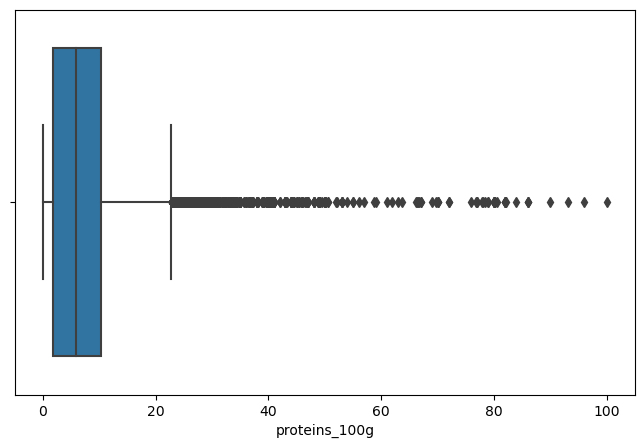

In [44]:
plt.figure(figsize=(8,5))
sns.boxplot(x=jeu0['proteins_100g'])
plt.show()

Elle permet de représenter schématiquement une distribution, en incluant sa dispersion

#### Le distibution du feature *sugar* par rapport à la fréquence

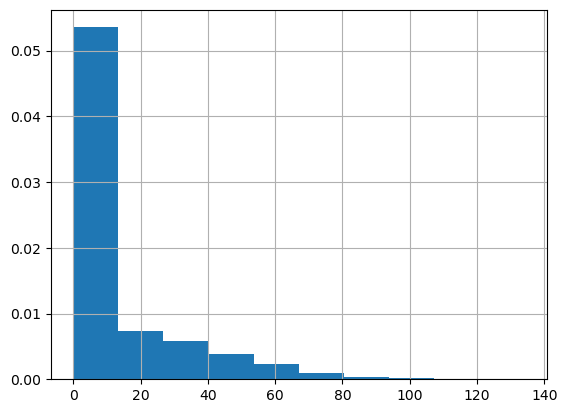

In [45]:
jeu0["sugars_100g"].hist(density=True)
plt.show()

#### Le distibution du feature *carbohydrates* par rapport à la fréquence

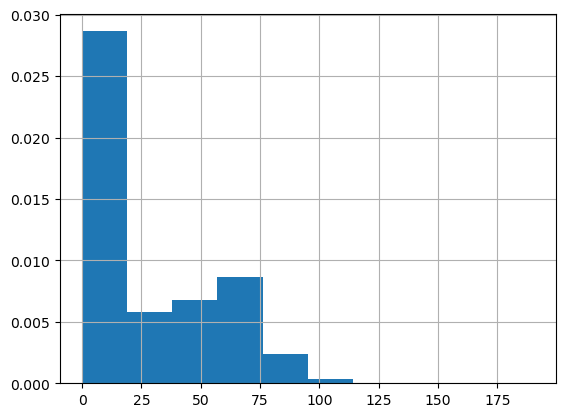

In [46]:
jeu0["carbohydrates_100g"].hist(density=True)
plt.show()

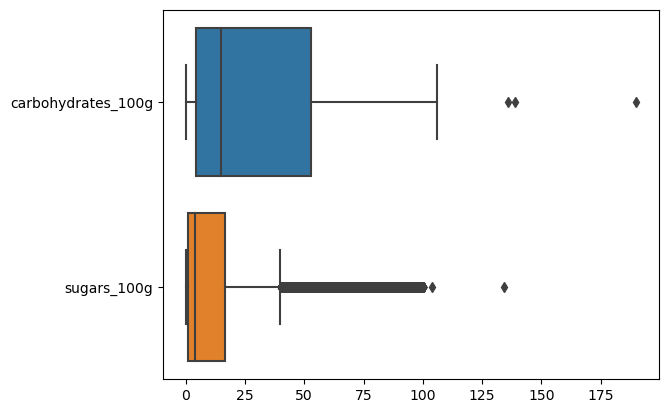

In [47]:
sns.boxplot(data=jeu0[["carbohydrates_100g", "sugars_100g"]], orient="h")
plt.show()

####                   Observation similtanée de la distribution de 2 features quantitatives

### 3.1.2 Variables qualitatives 

#### La distribution entre deux variables qualitatives categorielles

In [48]:
jeu0.describe(include="object")

,product_name,nutrition_grade_fr,pnns_groups_1
count,53733,53733,53733
unique,46239,5,14
top,Orange,d,unknown
freq,33,14599,9586


####  La distribution par modalité de la variable *pnns_groups* (catégorie de Food)

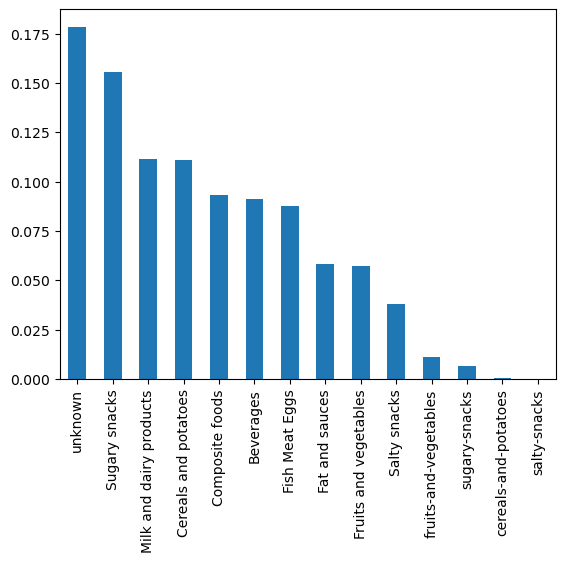

In [49]:
jeu0["pnns_groups_1"].value_counts(normalize=True).plot(kind='bar')# Diagramme en tuyaux d'orgues
plt.xlabel('\n', fontsize=10, color='red')
plt.show()

#### La repartition des produits par rapport à la variable categorielle *nutrigrade*

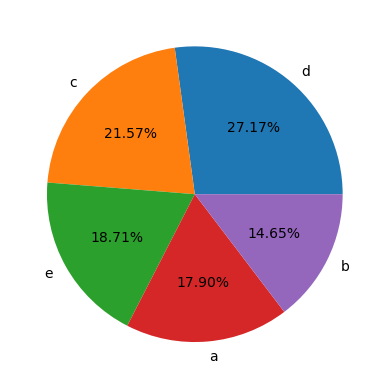

In [50]:
rep = (jeu0['nutrition_grade_fr'].value_counts())/len(jeu0)
rep
plt.pie(rep,labels=rep.index,autopct='%.2f%%')# Diagramme en secteurs
plt.show()

#### Le nombre de produit par typeProduits

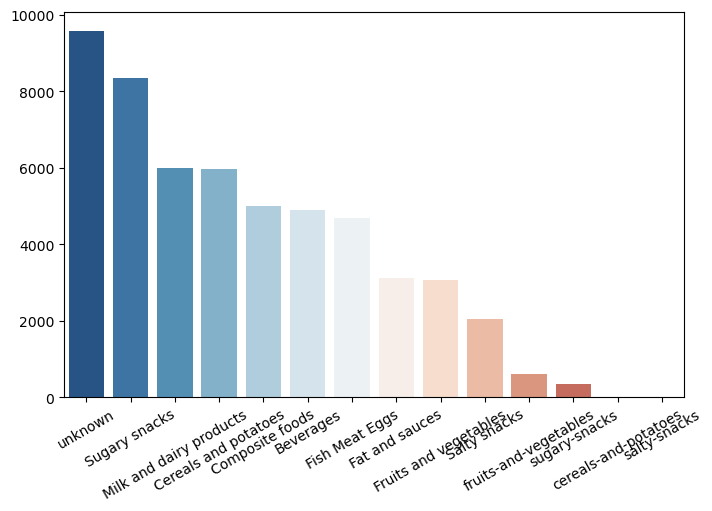

In [51]:
NbrTypeProd = jeu0['pnns_groups_1'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=NbrTypeProd.index, y=NbrTypeProd.values, palette="RdBu_r") # Diagramme en bâtons(barres)
plt.xticks(rotation= 30);


## 3.2 Analyses bivariées

In [53]:
es = jeu0.groupby('nutrition_grade_fr')['sugars_100g'].mean().reset_index()
es

,nutrition_grade_fr,sugars_100g
0,a,3.972864
1,b,4.991314
2,c,9.774927
3,d,16.723500
4,e,26.493834


#### - La moyenne en pourcentage de sucre contenu dans les produits selon leur classification nutrigrade (a,b,c,d,e) 

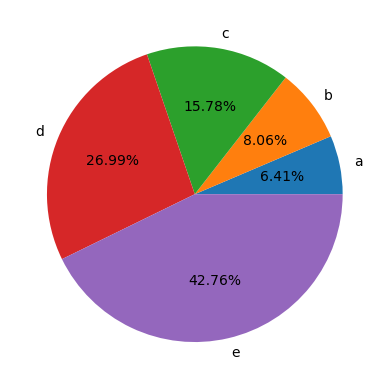

In [56]:
plt.pie(x=es['sugars_100g'], labels=es['nutrition_grade_fr'],  radius=1, autopct='%.2f%%')
plt.show()

#### - Le pourcentage de graisse en moyenne contenu dans les produits selon leur classification nutrigrade (a,b,c,d,e) 

- Le volume de sucre en moyenne contenu dans les produits classés par catégorie nutrigrade

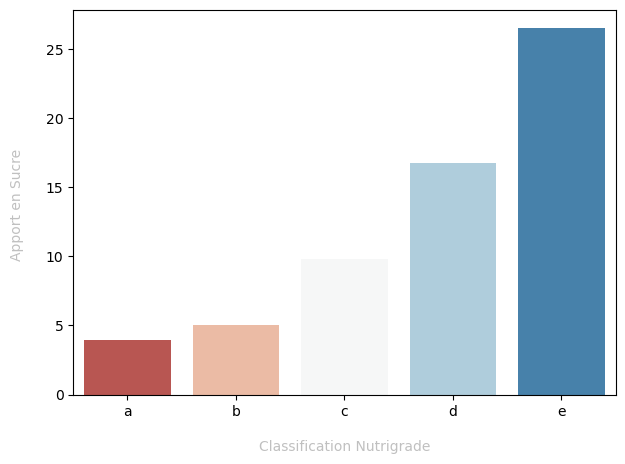

In [58]:
plt.figure(figsize=(7,5))
sns.barplot(x=es['nutrition_grade_fr'], y=es['sugars_100g'], palette="RdBu")
plt.xlabel('\nClassification Nutrigrade', fontsize=10, color='silver')
plt.ylabel("Apport en Sucre \n", fontsize=10, color='silver')
plt.show()

###  *Analysez deux variables qualitatives avec le Chi-2*

Pour savoir s'il y a une eventuelle corrélation entre les differentes fonctionalités, voici le tableau de contingence

In [61]:
X = "pnns_groups_1"
Y = "nutrition_grade_fr" 
cont = round(jeu0[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total"),2)
cont

nutrition_grade_fr,a,b,c,d,e,Total
pnns_groups_1,,,,,,
Beverages,221.0,697.0,1370.0,793.0,1810.0,4891
Cereals and potatoes,2995.0,931.0,1201.0,745.0,102.0,5974
Composite foods,1175.0,1583.0,1421.0,769.0,66.0,5014
Fat and sauces,86.0,212.0,826.0,1395.0,608.0,3127
Fish Meat Eggs,475.0,650.0,1251.0,1393.0,928.0,4697
Fruits and vegetables,2085.0,532.0,416.0,42.0,2.0,3077
Milk and dairy products,549.0,1181.0,1504.0,2522.0,234.0,5990
Salty snacks,48.0,72.0,583.0,1017.0,329.0,2049
Sugary snacks,64.0,282.0,745.0,2999.0,4266.0,8356


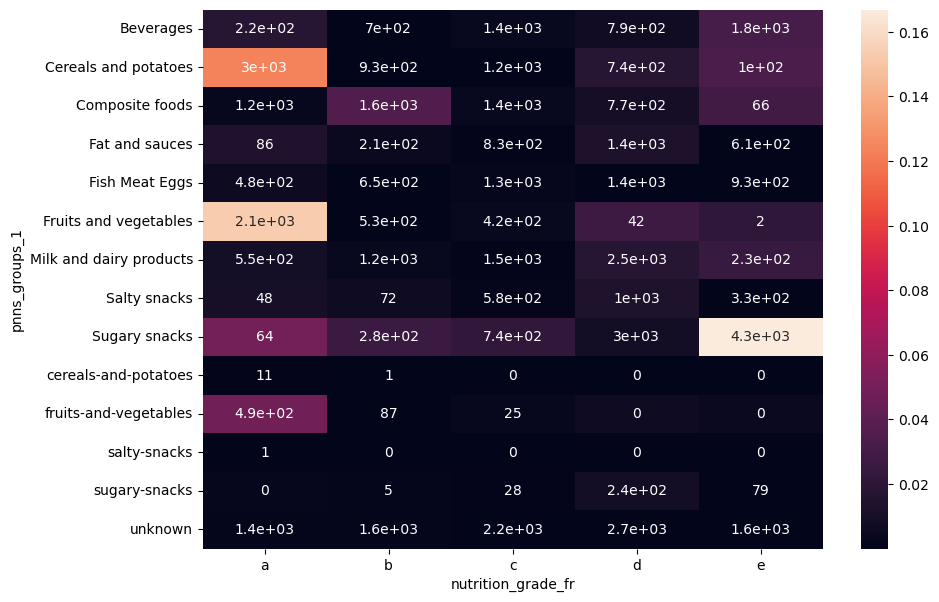

In [62]:
import seaborn as sns
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(jeu0)
indep = tx.dot(ty) / n
c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
plt.figure(figsize=(10, 7))
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()

On peut conclure que la catégorie nutrigrade E semble contribuer de façon importante à une éventuelle corrélation avec la categorie Sugary snacks.Lorsque qu'on regarde les contributions à la dépendance certaines  cases de la catégorie A et pnns_group_1 avec des valeurs proche de 0.5 et de 0.2 et autres, elle semble donc contribuer de façon importante à la corrélation.
Lorsque l'on regarde les contributions à la dépendance de chaque case de la catégorie C,D  elles semblent être proche de 0, ce qui indique finalement que cette catégorie ne contribue que très peu (voire pas du tout) à une éventuelle corrélation.


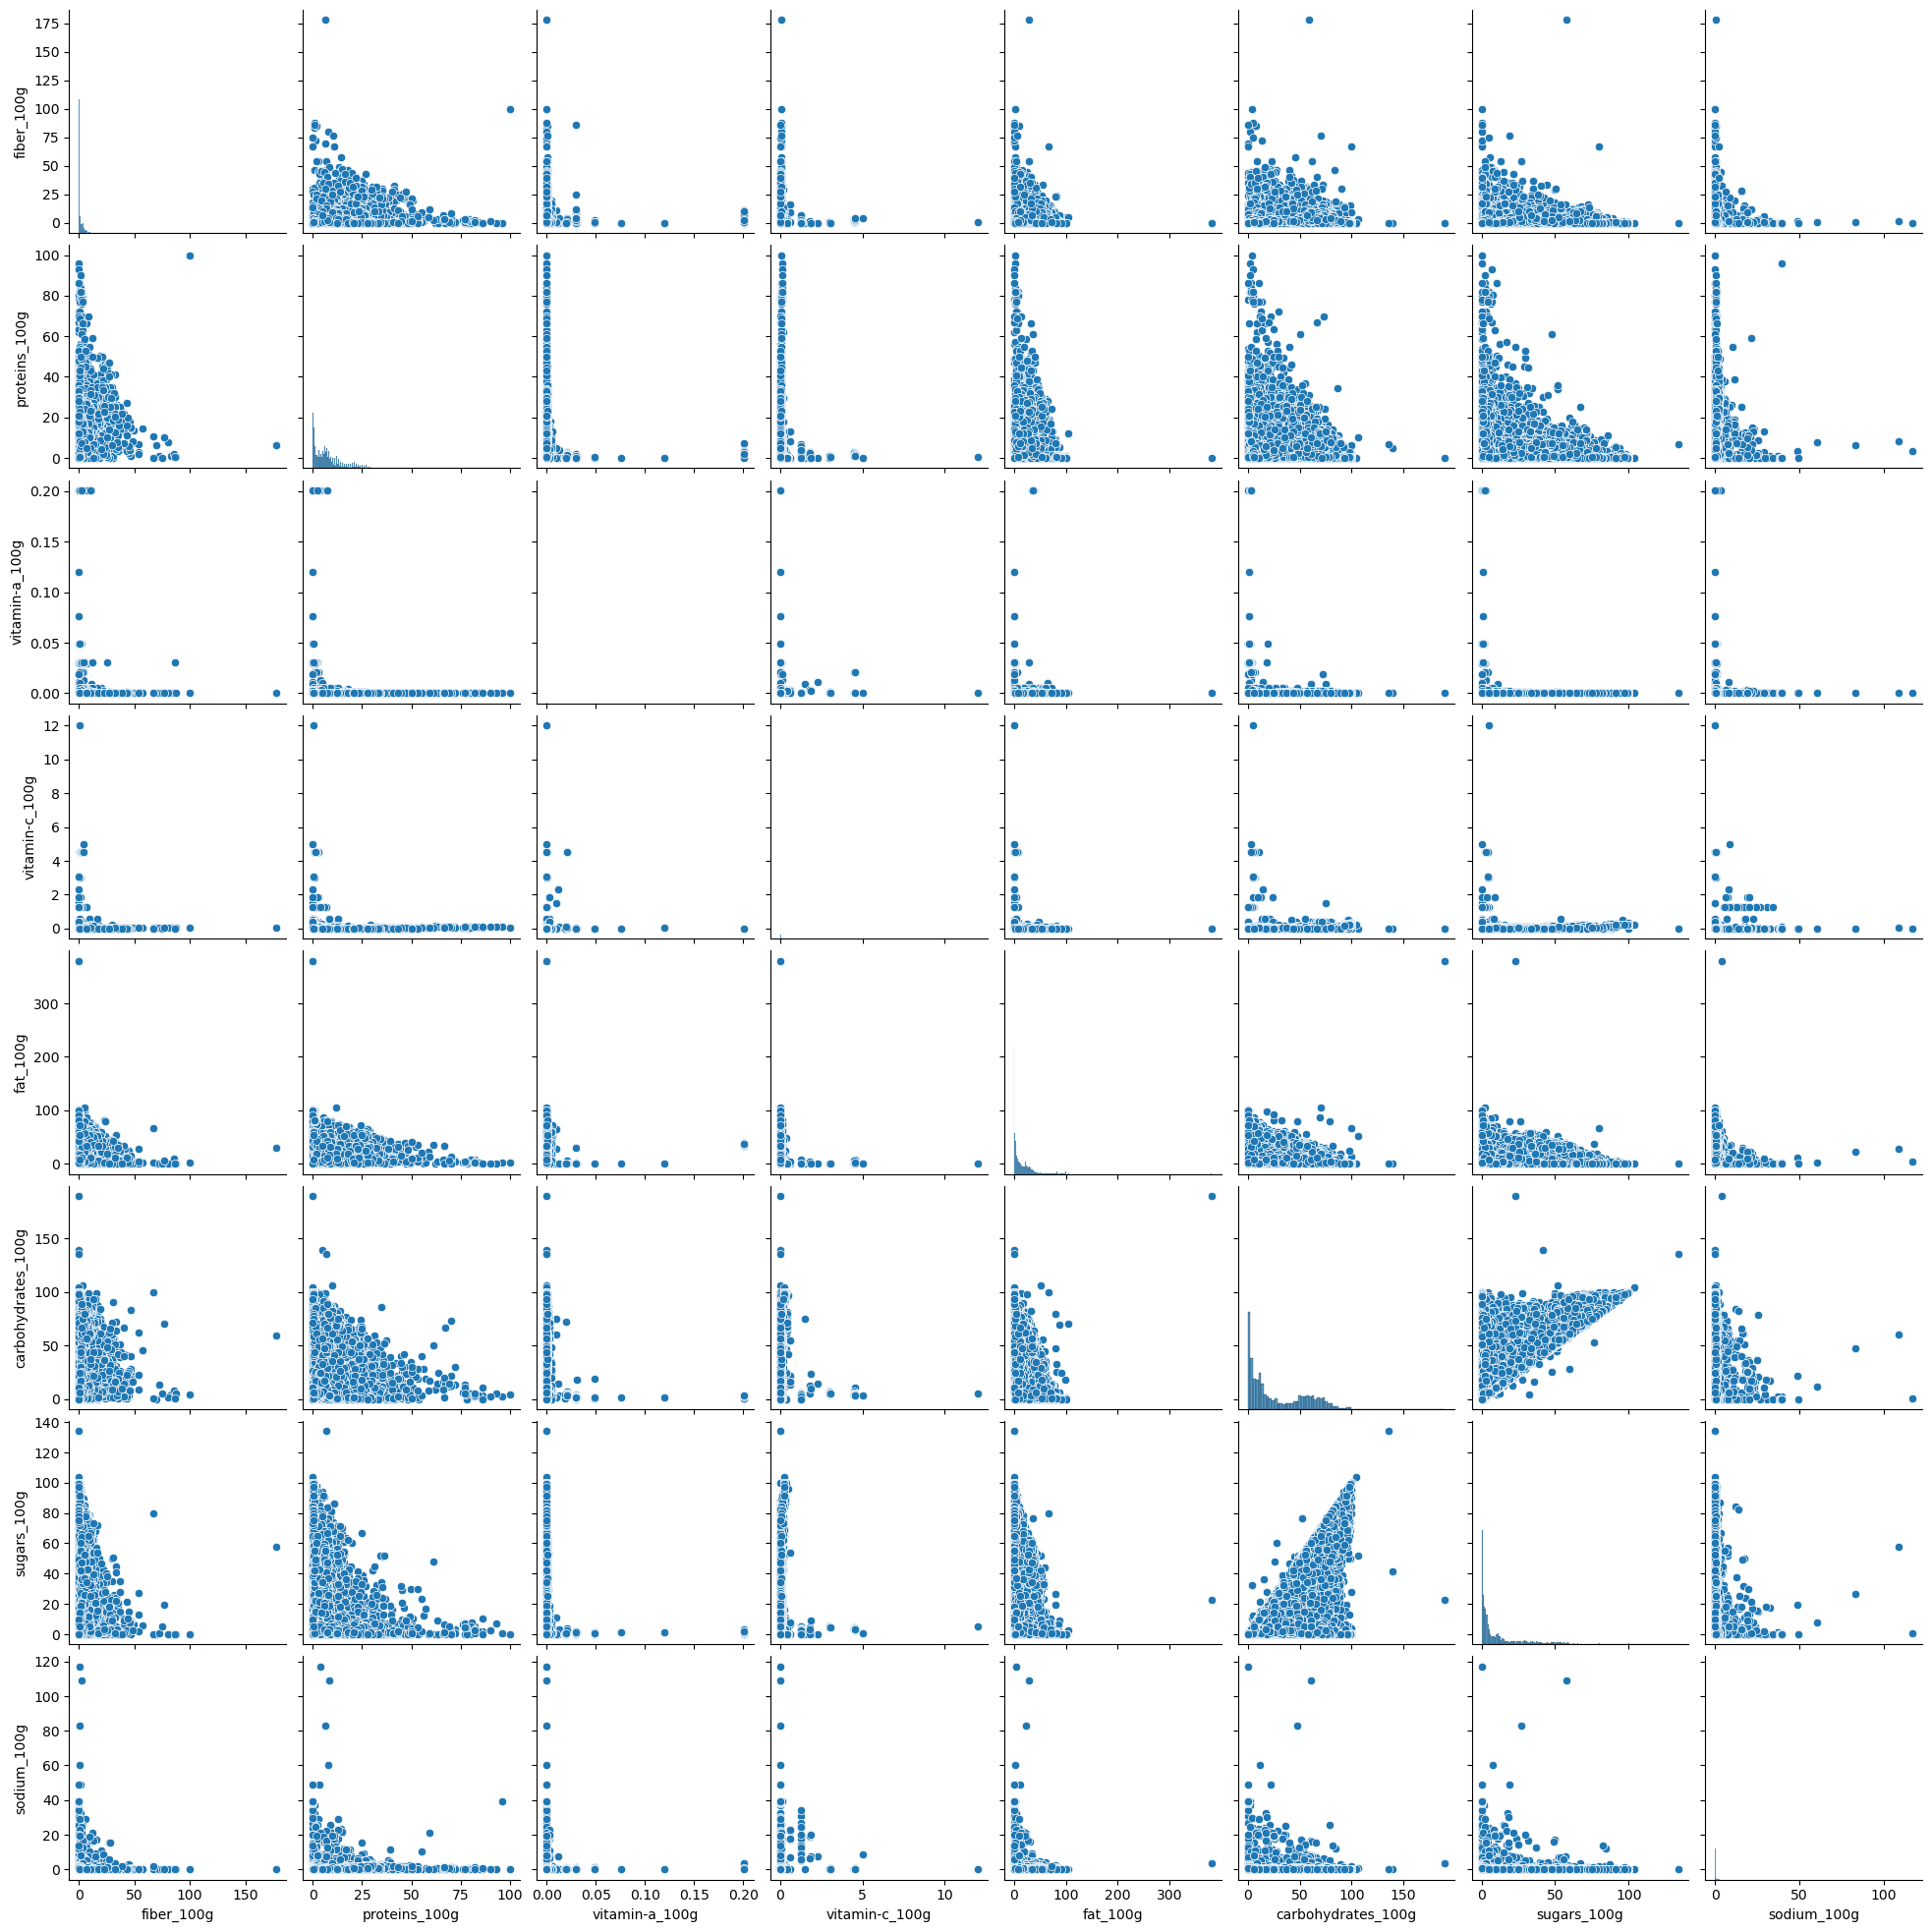

In [63]:
sns.pairplot(jeu0)

<AxesSubplot:>

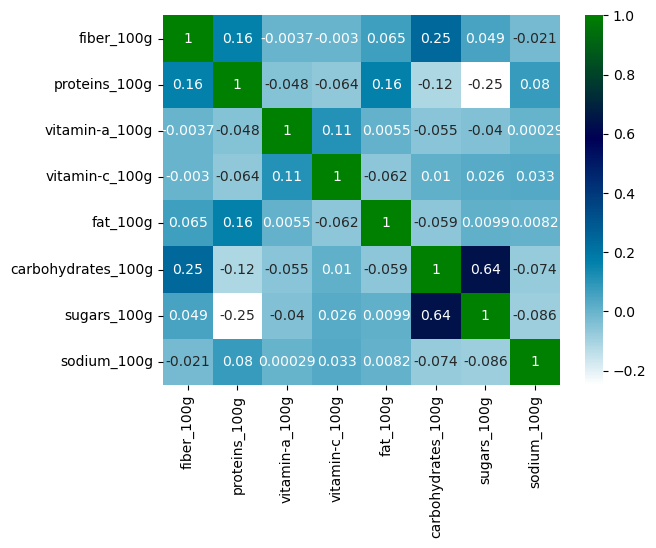

In [64]:
corr_matrix = jeu0.corr()
sns.heatmap(corr_matrix,annot=True,cmap="ocean_r")

Il y a correlation positive  entre les variables carbohydrates_100g et sugars_100g (0.6) (les 2 variables bougent dans la m^md dirction)	

#### Analyse des relations entre les differentes fonctionnalités et Nutrigrade

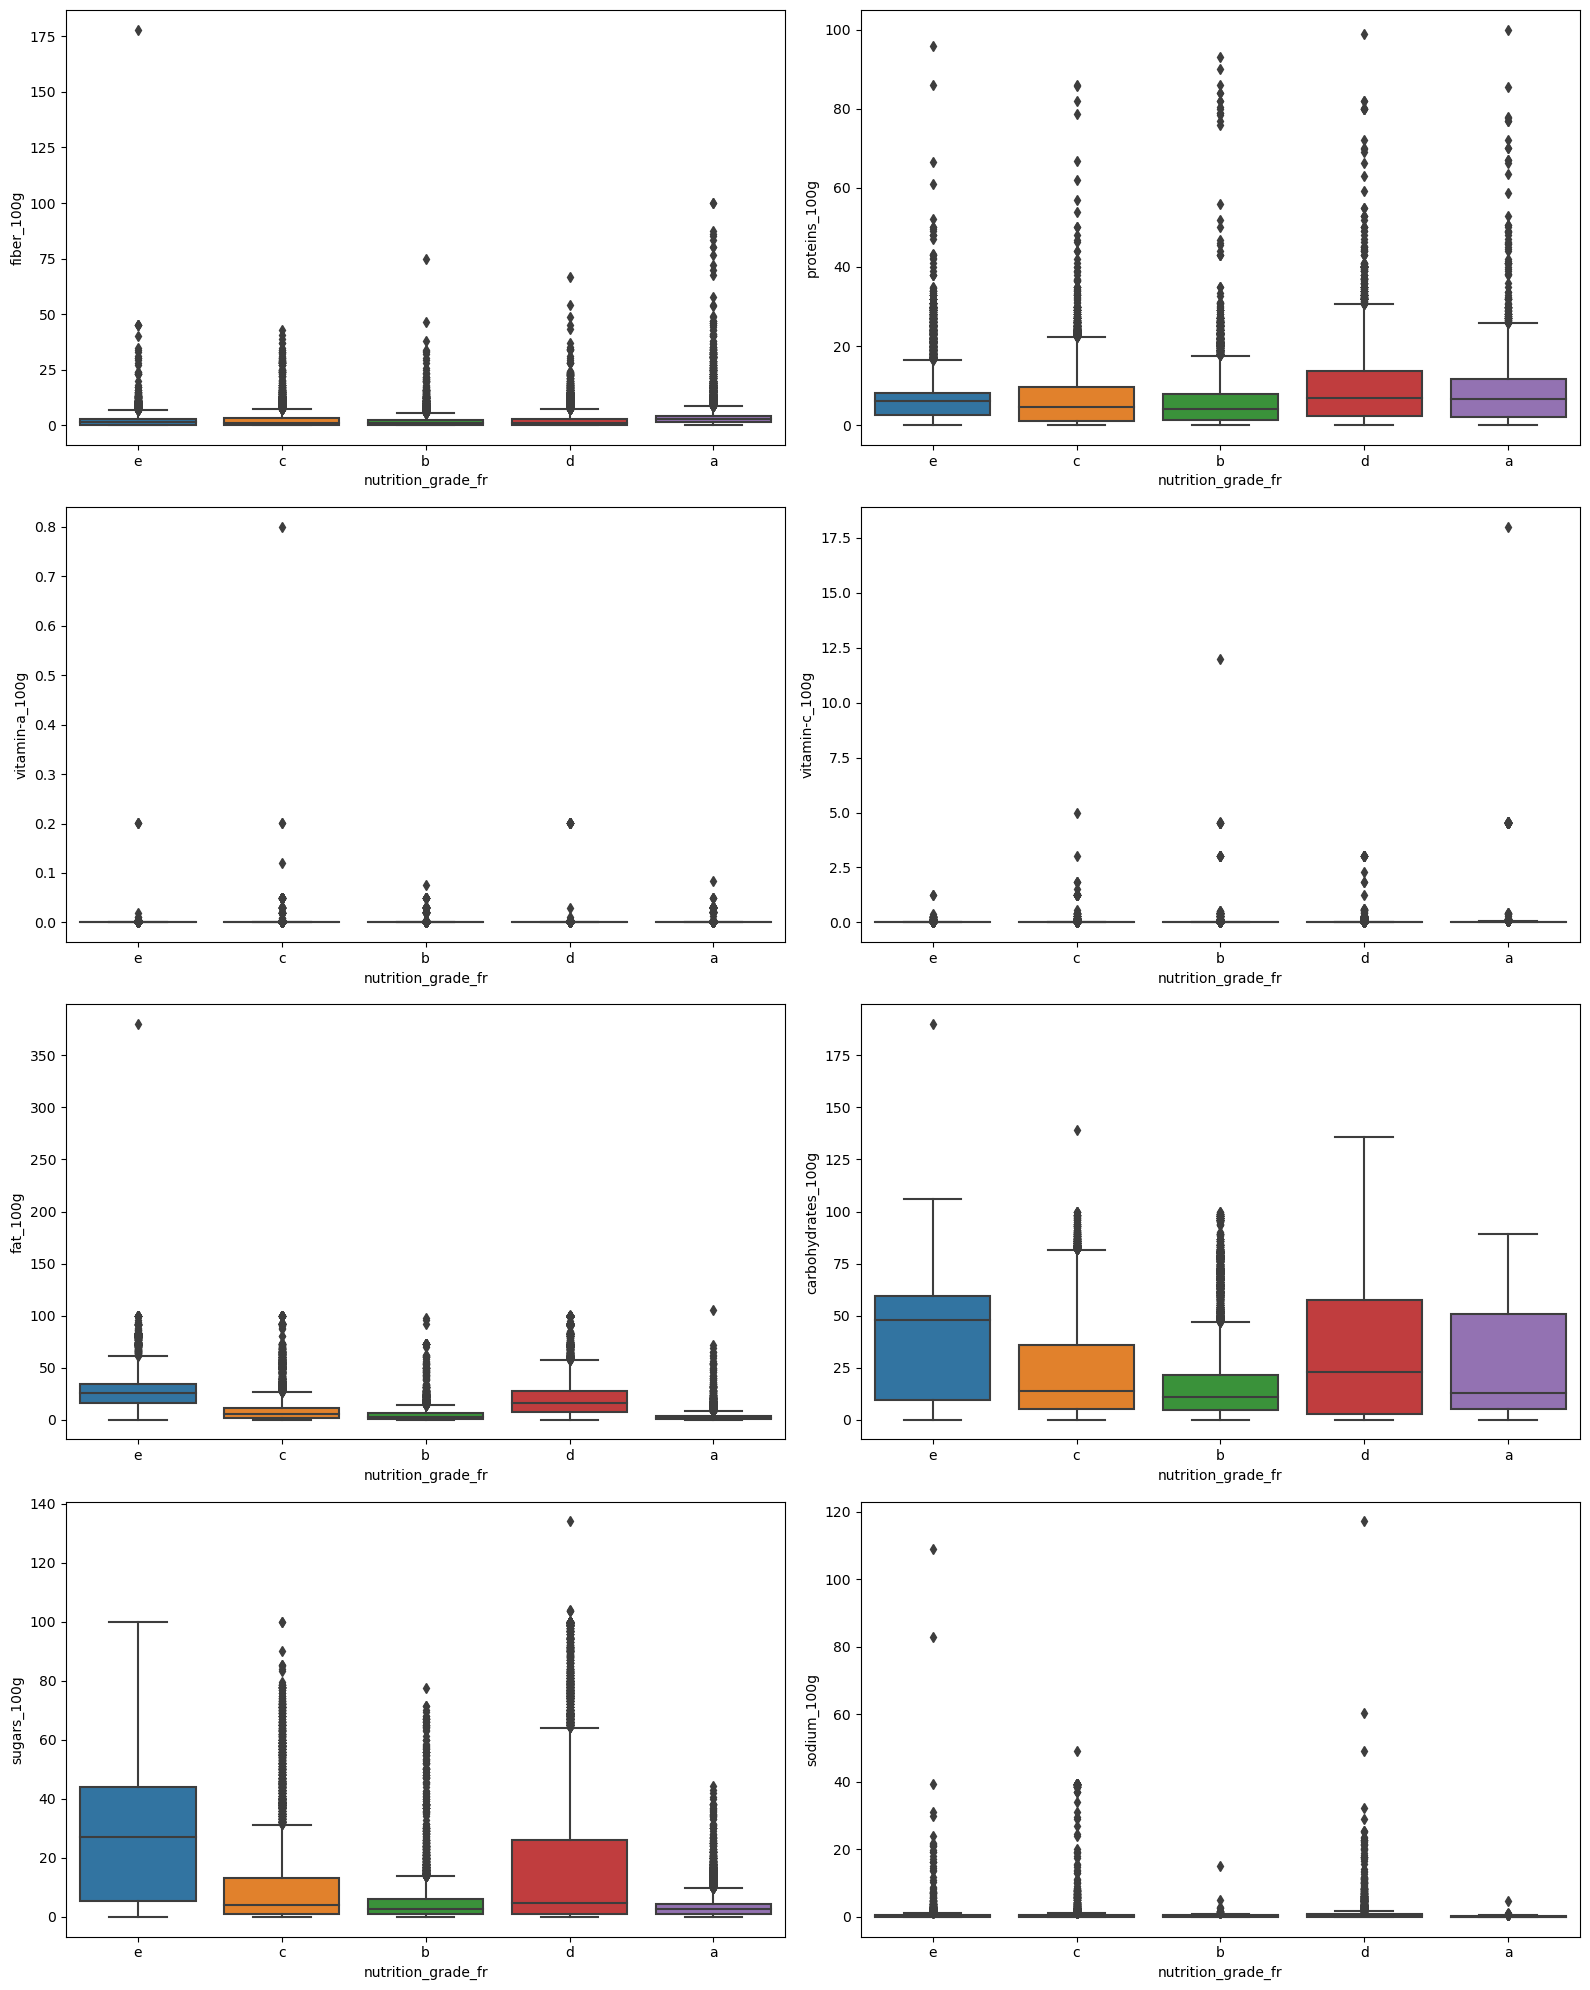

In [65]:
fig,ax = plt.subplots(nrows = 4, ncols=2, figsize=(16,20))
row = 0
col = 0
for i in range(len(df.columns) -1):
    if col > 1:
        row += 1
        col = 0
    axes = ax[row,col]
    sns.boxplot(x =df['nutrition_grade_fr'], y =df[df.columns[i]],ax = axes)
    col += 1
plt.tight_layout()
plt.show()

In [66]:
jeuD = jeu0_C.drop(columns =['fiber_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'sodium_100g','pnns_groups_1'])

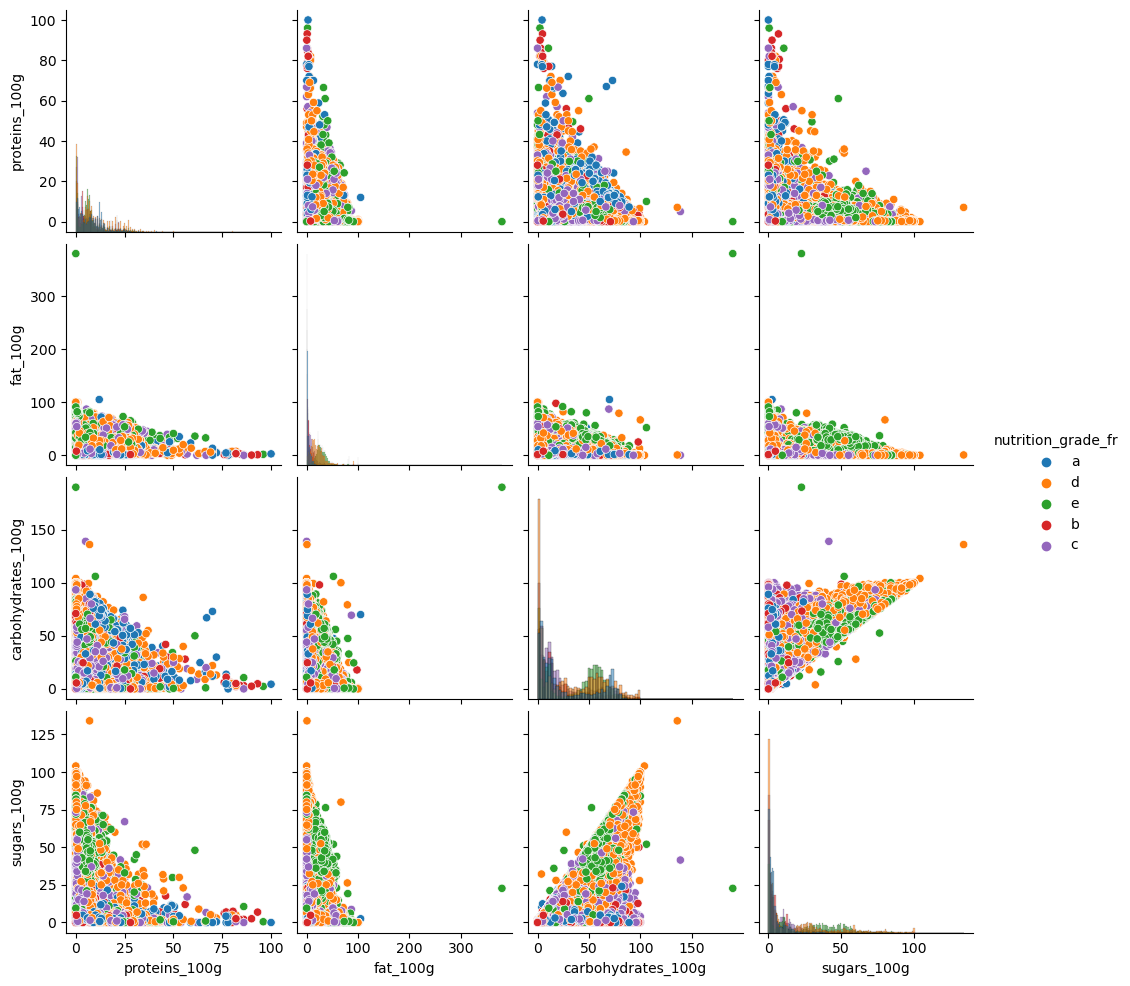

In [67]:
sns.pairplot(jeuD, hue ="nutrition_grade_fr", diag_kind="hist")

###  *Analyse de deux variables qualitatives avec Anova* 

#### Test Anova sur les features *carbohydrates_100g* et *nutrition_grade*

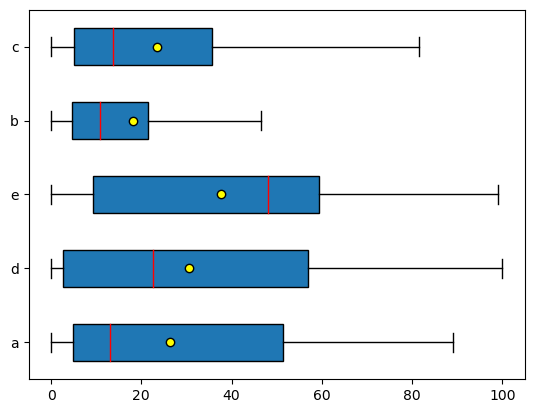

In [68]:
X = "nutrition_grade_fr" 
Y = "carbohydrates_100g"
sous_echantillon = jeu0[jeu0["carbohydrates_100g"] < 100].copy()

modalites = sous_echantillon[X].unique()
groupes = []
for i in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==i][Y])

# Propriétés graphiques   
medianprops = {'color':"red"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'yellow'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [69]:
X = "nutrition_grade_fr" 
Y = "carbohydrates_100g"
sous_echantillon = jeu0[jeu0["carbohydrates_100g"] < 100].copy()
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.052812341717515164

eta_squared = 0.05281 est plus proche de 0 que de 1 donc il n'y a pas de correletion entre le nutrigrade et le carbohydrates. 

#### Test Anova sur les features *fiber* et *nutrition_grade*

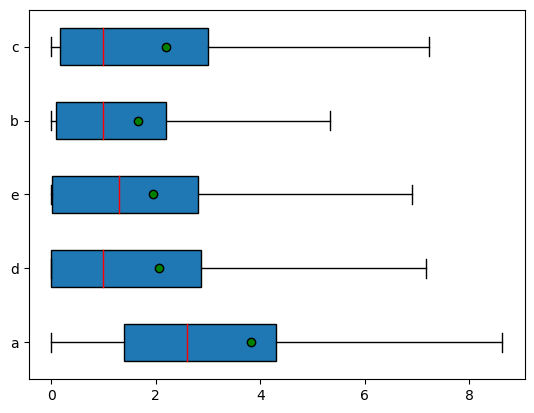

In [70]:
Y = "fiber_100g"
X = "nutrition_grade_fr"
sous_echantillon = jeu0[jeu0["fiber_100g"] < 100].copy()

modalites = sous_echantillon[X].unique()
groupes = []
for j in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==j][Y])  
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'green'}
medianprops = {'color':"red"}
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [71]:
Y = "fiber_100g"
X = "nutrition_grade_fr"
sous_echantillon = jeu0[jeu0["fiber_100g"] < 100].copy()
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.04097446139940187

eta_squared = 0.04097 qui est beaucoup plus proche de 0 que de 1 donc il n'y a pas de correletion entre le nutrigrade et le fiber

##### Conclusion:  Le test ANOVA (l'homogénéité de la moyenne de la variable quantitative étudiée sur les différentes valeurs de la variable qualitative). Dans notre cas l'analyse de la variance  aboutit à un résultat proche de zéro donc l'hypothèse nulle est retenue : La variable qualitative n'influe pas sur la variable quantitative

## 3.3 Analyses multivariées (ACP)

#### Preparation des données

In [72]:
jeu0 = jeu0.set_index('product_name', drop=True)

In [73]:
jeu0_C=jeu0

In [74]:
sell = ['fiber_100g','proteins_100g','vitamin-a_100g','vitamin-c_100g','fat_100g','carbohydrates_100g','sugars_100g','sodium_100g']
jeu0 = jeu0[sell]

In [75]:
jeu0

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
product_name,,,,,,,,
Foie de veau,0.00,20.0,0.000000,0.000000,4.8,2.9,0.0,0.074803
Bonbons craie,0.00,1.9,0.000000,0.001500,1.8,88.0,74.0,0.070866
Tropifrutti,0.55,4.5,0.000000,0.012750,0.5,82.0,63.0,0.011811
Oro di Parma Tomaten stückig,0.85,1.1,0.020847,0.027250,0.2,3.0,3.0,0.078740
Butter,0.00,0.5,0.000707,0.000000,81.7,0.0,0.0,0.800000
...,...,...,...,...,...,...,...,...
Velouté de Poireaux Pommes de Terre et Pointe de Crème,0.70,1.0,0.000095,0.004926,2.5,4.8,0.8,0.750000
Poire,0.00,0.0,0.000090,0.025000,0.0,11.0,9.5,0.003000
filets de thon au naturel,0.00,28.0,0.000000,0.000275,1.3,0.0,0.0,0.433071


In [76]:
X = jeu0.values
X[:5]

array([[0.00000000e+00, 2.00000000e+01, 0.00000000e+00, 0.00000000e+00,
        4.80000000e+00, 2.90000000e+00, 0.00000000e+00, 7.48031496e-02],
       [0.00000000e+00, 1.90000000e+00, 0.00000000e+00, 1.50000000e-03,
        1.80000000e+00, 8.80000000e+01, 7.40000000e+01, 7.08661417e-02],
       [5.50000000e-01, 4.50000000e+00, 0.00000000e+00, 1.27500000e-02,
        5.00000000e-01, 8.20000000e+01, 6.30000000e+01, 1.18110236e-02],
       [8.50000000e-01, 1.10000000e+00, 2.08468750e-02, 2.72500000e-02,
        2.00000000e-01, 3.00000000e+00, 3.00000000e+00, 7.87401575e-02],
       [0.00000000e+00, 5.00000000e-01, 7.06750000e-04, 0.00000000e+00,
        8.17000000e+01, 0.00000000e+00, 0.00000000e+00, 8.00000000e-01]])

In [77]:
type(X)

numpy.ndarray

In [78]:
X.shape

(53733, 8)

In [79]:
ccod = jeu0.index
ccod

Index(['Foie de veau', 'Bonbons craie', 'Tropifrutti',
       'Oro di Parma Tomaten stückig', 'Butter',
       'Easy Cook Long Grain Rice (XXL)',
       'Paquito, Pocket Compote Pomme, Pomme fraise, Pomme banane, 5 fruits, les 24 gourdes de 90 g',
       'Soupe courgettes et vache qui rit', 'Torti au surimi',
       'Ïod Truite fumée',
       ...
       'St Moret', '10 œufs frais moyens',
       'Mermelada de kiwi &quot;Helios&quot;', 'Free',
       'Riche en Omega 3 (Tartine & Cuisson) 250 g - Bouton d'Or',
       'Velouté de Poireaux Pommes de Terre et Pointe de Crème', 'Poire',
       'filets de thon au naturel', 'Hafer Creme Cuisine',
       'Chocolat Club Cappuccino'],
      dtype='object', name='product_name', length=53733)

In [80]:
features = jeu0.columns
features

Index(['fiber_100g', 'proteins_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'sodium_100g'],
      dtype='object')

In [81]:
scaler = StandardScaler()

In [82]:
scaler.fit(X)

StandardScaler()

In [83]:
X_scaled = scaler.transform(X)
X_scaled[:5]

array([[-0.63657007,  1.67306582, -0.08085795, -0.11122236, -0.51220438,
        -0.92087191, -0.70544447, -0.20227408],
       [-0.63657007, -0.7520789 , -0.08085795, -0.10236186, -0.69249001,
         2.22014368,  3.29446018, -0.20462547],
       [-0.486569  , -0.40371557, -0.08085795, -0.03590812, -0.77061378,
         1.99868547,  2.69987976, -0.23989629],
       [-0.40475023, -0.85926762,  4.54943541,  0.04974336, -0.78864234,
        -0.91718094, -0.54328617, -0.1999227 ],
       [-0.63657007, -0.93965916,  0.07611809, -0.11122236,  4.10911725,
        -1.02791005, -0.70544447,  0.23085159]])

In [84]:
X_scaled = scaler.fit_transform(X)

In [85]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7
mean,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [86]:
n_components = 8

In [87]:
pca = PCA(n_components=n_components)

In [88]:
pca.fit(X_scaled)

PCA(n_components=8)

In [89]:
pca.explained_variance_ratio_

array([0.22433171, 0.16288976, 0.13686216, 0.12440288, 0.11765141,
       0.10808694, 0.08636762, 0.03940751])

In [90]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([22.43, 16.29, 13.69, 12.44, 11.77, 10.81,  8.64,  3.94])

In [91]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 22.,  39.,  52.,  65.,  77.,  87.,  96., 100.])

In [92]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8]

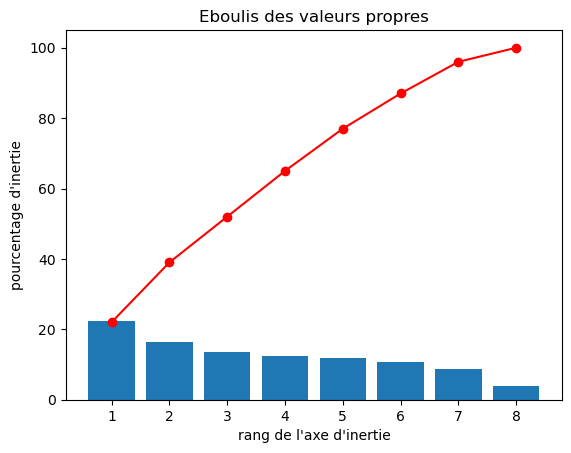

In [93]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On a en bleu la variance de chaque nouvelle composante, et en rouge la variance cumulée.

On voit ici que environ 40% de la variance est comprise dans les 2 premières composantes, et plus de 80% dans les 6 premières.

In [94]:
pcs = pca.components_
pcs

array([[-0.17797001,  0.29777479,  0.05392519, -0.04591573,  0.09243417,
        -0.64800247, -0.64763651,  0.16357364],
       [ 0.55190065,  0.57102909, -0.22530221, -0.28692459,  0.44859959,
         0.18044454,  0.00826004,  0.04872968],
       [ 0.34633287,  0.13715229,  0.62065353,  0.64016914,  0.06823101,
         0.06674417, -0.02278159,  0.23787855],
       [ 0.00705209,  0.06781099, -0.4333095 ,  0.13074996, -0.35989147,
         0.10657586,  0.02932389,  0.80545583],
       [-0.43998338, -0.15836006,  0.16231461, -0.10901103,  0.70050922,
         0.00775184,  0.2687513 ,  0.42438988],
       [-0.14973494,  0.0662728 , -0.56490681,  0.68982413,  0.31500657,
        -0.07127508,  0.02354725, -0.27082573],
       [ 0.54097494, -0.72146134, -0.16697041, -0.02685842,  0.23026649,
        -0.21485064, -0.21682065,  0.10974747],
       [ 0.18728679,  0.10895145, -0.0042674 , -0.01385019, -0.11433298,
        -0.69312217,  0.6777366 ,  0.00509239]])

In [95]:
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5,6,7
0,-0.177970,0.297775,0.053925,-0.045916,0.092434,-0.648002,-0.647637,0.163574
1,0.551901,0.571029,-0.225302,-0.286925,0.448600,0.180445,0.008260,0.048730
2,0.346333,0.137152,0.620654,0.640169,0.068231,0.066744,-0.022782,0.237879
3,0.007052,0.067811,-0.433309,0.130750,-0.359891,0.106576,0.029324,0.805456
4,-0.439983,-0.158360,0.162315,-0.109011,0.700509,0.007752,0.268751,0.424390
5,-0.149735,0.066273,-0.564907,0.689824,0.315007,-0.071275,0.023547,-0.270826
6,0.540975,-0.721461,-0.166970,-0.026858,0.230266,-0.214851,-0.216821,0.109747
7,0.187287,0.108951,-0.004267,-0.013850,-0.114333,-0.693122,0.677737,0.005092


In [96]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
F1,-0.18,0.30,0.05,-0.05,0.09,-0.65,-0.65,0.16
F2,0.55,0.57,-0.23,-0.29,0.45,0.18,0.01,0.05
F3,0.35,0.14,0.62,0.64,0.07,0.07,-0.02,0.24
F4,0.01,0.07,-0.43,0.13,-0.36,0.11,0.03,0.81
F5,-0.44,-0.16,0.16,-0.11,0.70,0.01,0.27,0.42
F6,-0.15,0.07,-0.56,0.69,0.32,-0.07,0.02,-0.27
F7,0.54,-0.72,-0.17,-0.03,0.23,-0.21,-0.22,0.11
F8,0.19,0.11,-0.00,-0.01,-0.11,-0.69,0.68,0.01


In [97]:
pcs.T

,F1,F2,F3,F4,F5,F6,F7,F8
fiber_100g,-0.177970,0.551901,0.346333,0.007052,-0.439983,-0.149735,0.540975,0.187287
proteins_100g,0.297775,0.571029,0.137152,0.067811,-0.158360,0.066273,-0.721461,0.108951
vitamin-a_100g,0.053925,-0.225302,0.620654,-0.433309,0.162315,-0.564907,-0.166970,-0.004267
vitamin-c_100g,-0.045916,-0.286925,0.640169,0.130750,-0.109011,0.689824,-0.026858,-0.013850
fat_100g,0.092434,0.448600,0.068231,-0.359891,0.700509,0.315007,0.230266,-0.114333
carbohydrates_100g,-0.648002,0.180445,0.066744,0.106576,0.007752,-0.071275,-0.214851,-0.693122
sugars_100g,-0.647637,0.008260,-0.022782,0.029324,0.268751,0.023547,-0.216821,0.677737
sodium_100g,0.163574,0.048730,0.237879,0.805456,0.424390,-0.270826,0.109747,0.005092


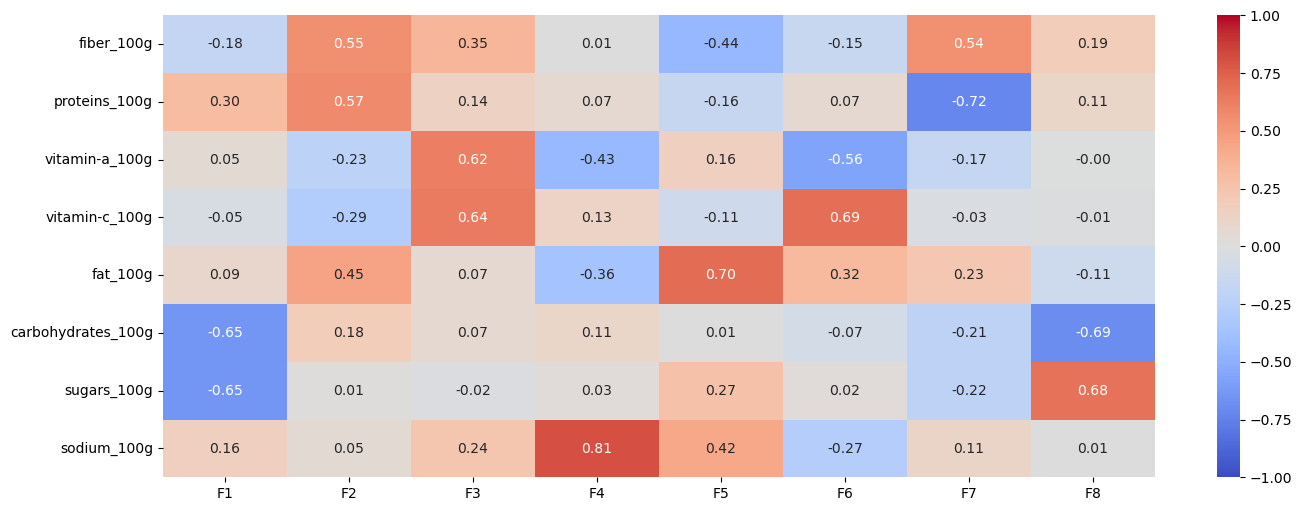

In [98]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.show()

Graphe de correlation 

In [99]:
x, y = 0,1

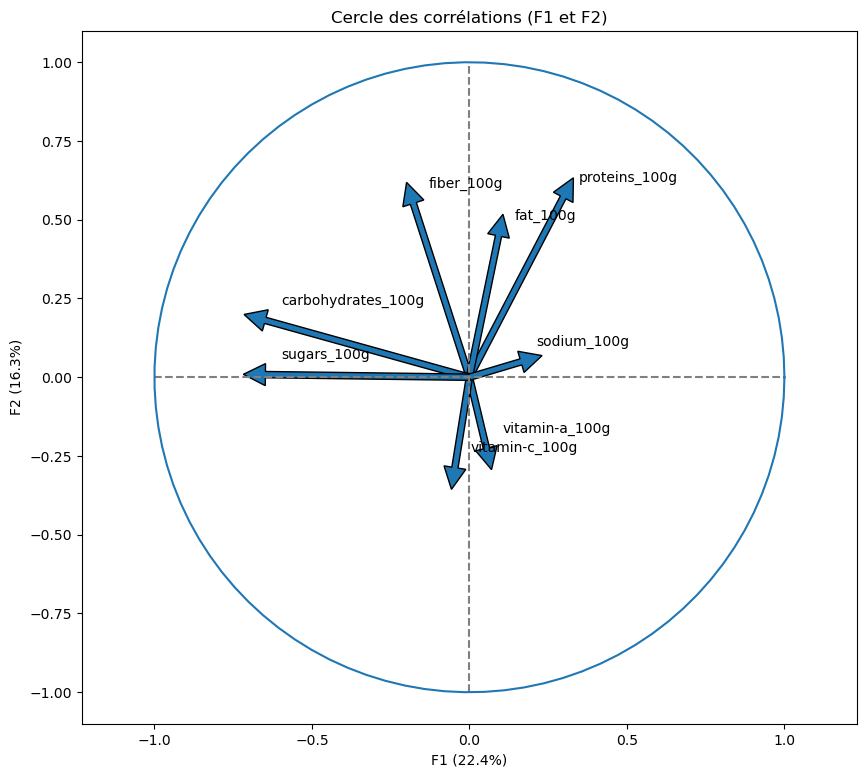

In [100]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0, 
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)

- Créeons la fonction de correlation 

In [101]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
   
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

Pour F1 et F2 il faut bien préciser  0 et 1  

In [102]:
x_y = (0,1)
x_y

(0, 1)

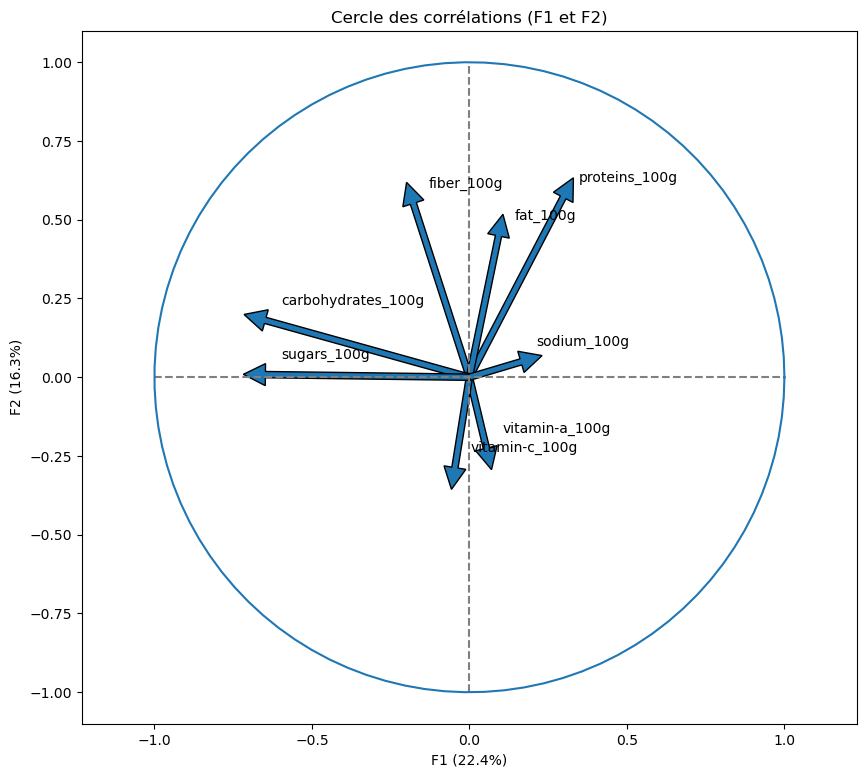

In [103]:
correlation_graph(pca, x_y, features)

Essayons pour F3 et F4 : 

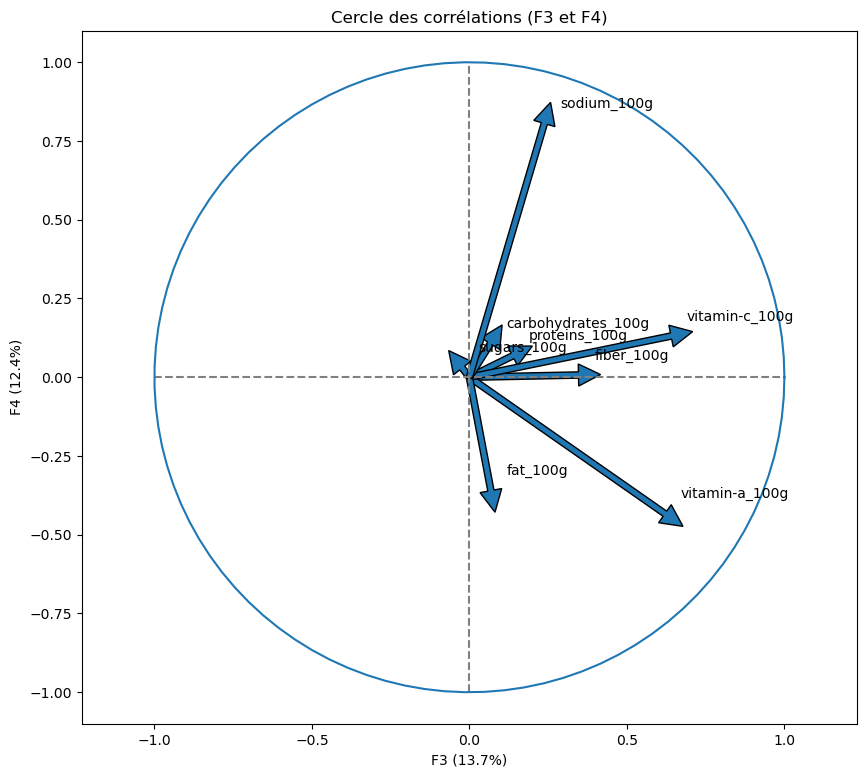

In [104]:
correlation_graph(pca, (2,3), features)

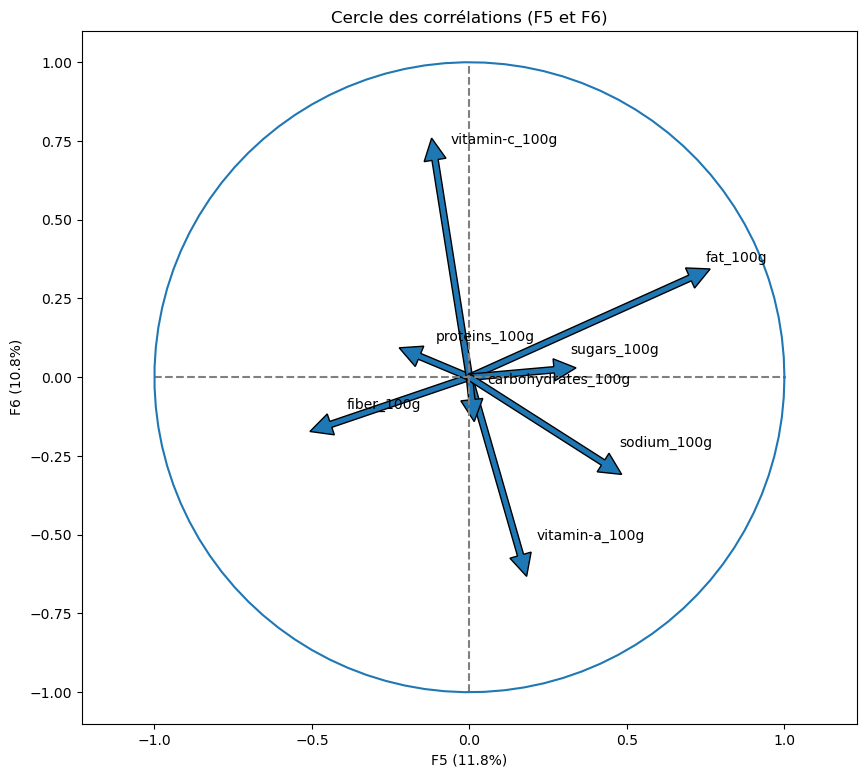

In [105]:
correlation_graph(pca, (4,5), features)

Projection

In [106]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[ 1.58540077,  0.24255098, -0.24084279,  0.03204337, -0.62724104,
         0.11760611, -1.32427034,  0.28265027],
       [-3.78007238, -0.62599165, -0.46212487,  0.3837889 ,  0.72787768,
        -0.22284657, -1.15874312,  0.57267941],
       [-3.19049875, -0.44498479, -0.3348103 ,  0.37582789,  0.36826271,
        -0.1896521 , -1.17607423,  0.39708811],
       [ 0.89979826, -2.28683384,  2.44723172, -2.01681561,  0.25675919,
        -2.67373777, -0.24867482,  0.16713725],
       [ 1.38323903,  0.7901566 , -0.09055168, -1.53886564,  3.23225255,
         1.2018509 ,  1.66916653, -0.45465312]])

In [107]:
x_y

(0, 1)

In [108]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[8,6], 
                                marker="." ):   

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)  
    if not figsize: 
        figsize = (7,6)
    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e
    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   
    x, y = x_y
    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters     
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c) 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')
    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1  
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)  
    if len(labels) :       
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')  
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

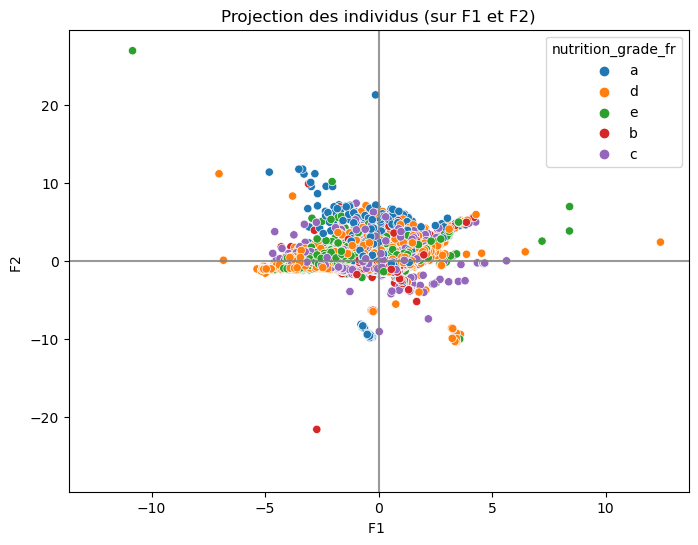

In [109]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=jeu0_C['nutrition_grade_fr'])

La version plus *élaborée* avec F1 et F2 

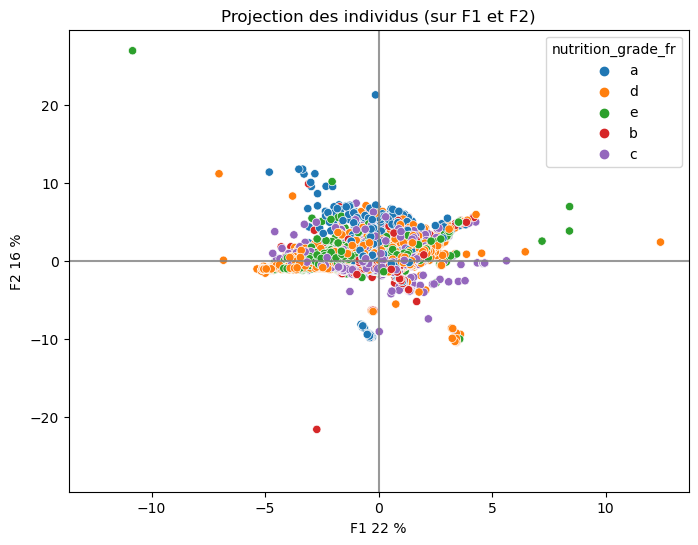

In [110]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca,  figsize=(8,6), clusters=jeu0_C['nutrition_grade_fr'], marker="o")

Essayons avec F2 et F3

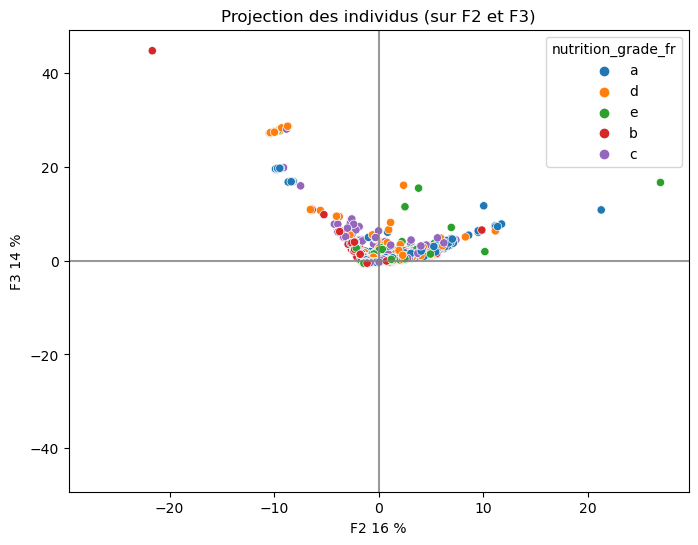

In [111]:
x_y = 1,2
display_factorial_planes(X_proj, x_y, pca,  figsize=(8,6), clusters=jeu0_C['nutrition_grade_fr'],marker="o")

Essayons avec F3 et F4

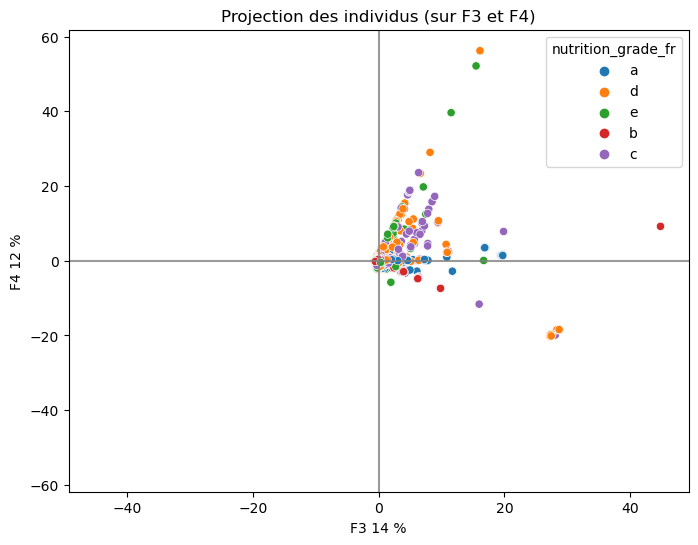

In [112]:
x_y = 2,3
display_factorial_planes(X_proj, x_y, pca,  figsize=(8,6), clusters=jeu0_C['nutrition_grade_fr'],marker="o")

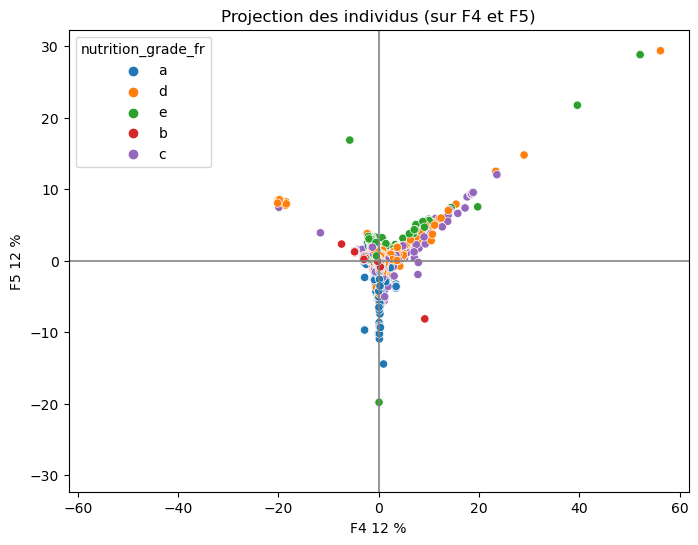

In [113]:
x_y = 3,4
display_factorial_planes(X_proj, x_y, pca,  figsize=(8,6), clusters=jeu0_C['nutrition_grade_fr'],marker="o")

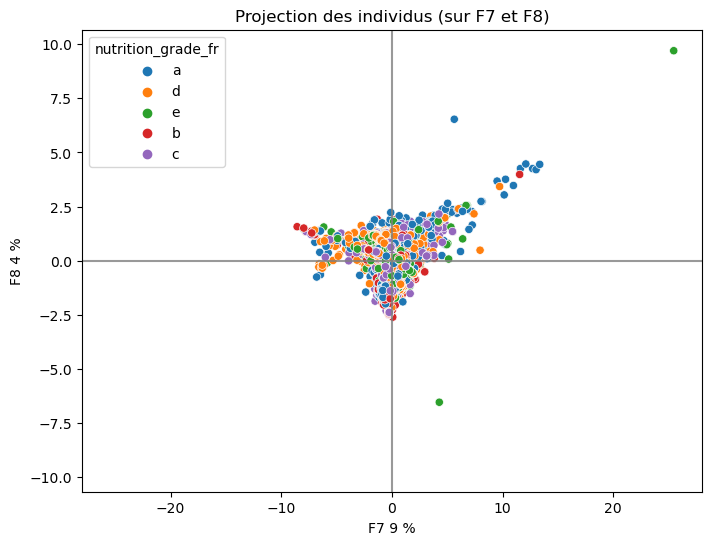

In [114]:
x_y = 6,7
display_factorial_planes(X_proj, x_y, pca,  figsize=(8,6), clusters=jeu0_C['nutrition_grade_fr'],marker="o")

## Conclusion

Durant l'analyse du jeu de données associé au projet, le constat est que la plupart des features ne sont pas rempli(quasiment vide), sur les 162 features c'est a peine si on peut exploiter 45 veritablement. je me pose la question sur la necessite réelle de leur existance.

- La RGPD signifie « Règlement Général sur la Protection des Données » Ce Règlement encadre le traitement des données personnelles sur le territoire de l'Union européenne.
#### Le principe de finalité.
le responsable d'un fichier ne peut enregistrer et utiliser des informations sur des personnes physiques que dans un but bien précis, légal et légitime ;
#### Le principe de proportionnalité et de pertinence.
les informations enregistrées doivent être pertinentes et strictement nécessaires au regard de la finalité du fichier ;
#### Le principe d'une durée de conservation limitée. 
il n'est pas possible de conserver des informations sur des personnes physiques dans un fichier pour une durée indéfinie. Une durée de conservation précise doit être fixée, en fonction du type d'information enregistrée et de la finalité du fichier ;
#### Le principe de sécurité et de confidentialité. 
le responsable du fichier doit garantir la sécurité des informations qu'il détient. Il doit en particulier veiller à ce que seules les personnes autorisées aient accès à ces informations ;
#### Les droits des personnes.

Malgré que nos données ne concernent pas des personnes, nous devons veiller à la fiabilité des informations que nous publions etant donné que cela concerne le domaine de la santé. Une erreur peux avoir de graves conséquences. Supposons qu'il est enregistré qu'un produit contient 60g de graisse pour 100g alors qu'en réalité sa contenance est de 60g pour 100g. Cela peut avoir des conséquences non negligeables sur la santé.